#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Ипорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor 
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
taxi=pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',sep=',')

In [3]:
def dataset_info(dataset,name):
    display(f'Анализ датафрейма {name}')
    display(dataset.head(5))
    display(f'Количество пустых ячеек:')
    display(dataset.isnull().sum())
    display(dataset.info())
    display(f'Количество явных дубликатов в датасете:{dataset.duplicated().sum()}' )
    dataset=dataset.drop_duplicates()
    display(f'Количество явных дубликатов в датасете после удаления:{dataset.duplicated().sum()}' )

In [4]:
dataset_info(taxi, 'taxi')

'Анализ датафрейма taxi'

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


'Количество пустых ячеек:'

datetime      0
num_orders    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

'Количество явных дубликатов в датасете:0'

'Количество явных дубликатов в датасете после удаления:0'

In [5]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])#.dt.normalize()
taxi.set_index("datetime", inplace = True)
taxi.sort_index(inplace=True)

In [6]:
def graphs(dataset,name):
    display(f'Анализ количественных признаков датафрейма {name}')
    display(dataset.describe())
    for j in dataset.columns:
        if dataset[j].dtype!=object:
            fig = plt.hist(dataset[j],color = 'blue', edgecolor = 'black',bins = 50)
            plt.xlabel(j)
            plt.ylabel('Количество')
            plt.title(f'Анализ столбца {j}',fontweight = "bold")
            plt.show()
            dataset.boxplot([j])
            plt.title(f'Boxplot для  столбца {j}')
            plt.show()

'Анализ количественных признаков датафрейма taxi'

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


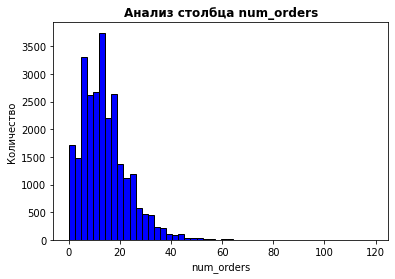

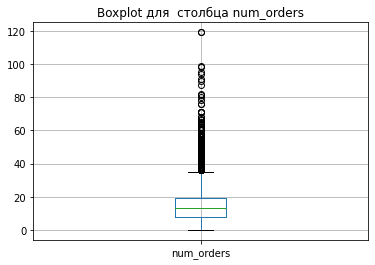

In [7]:
graphs(taxi, 'taxi')

In [8]:
taxi = taxi.resample('1H').sum()
decomposed = seasonal_decompose(taxi)
decomposed_day = seasonal_decompose(taxi.resample('1D').sum())

### Вывод
Данные загружены. Явные дубликаты, пустые ячейки не обнаружены 

## Анализ

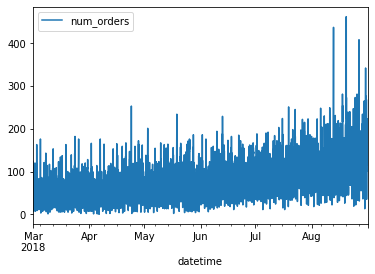

In [9]:
fig1 = taxi.plot()
plt.show()

In [10]:
def graphs_2(dataset,name):
    fig =plt.scatter(x=dataset.index, y=dataset)
    plt.ylabel('Количество заказов')
    plt.title(f'Анализ {name}',fontweight = "bold")
    #plt.show()

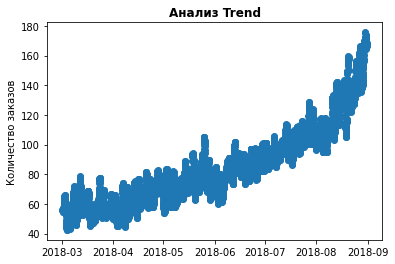

In [11]:
graphs_2(decomposed.trend, 'Trend')

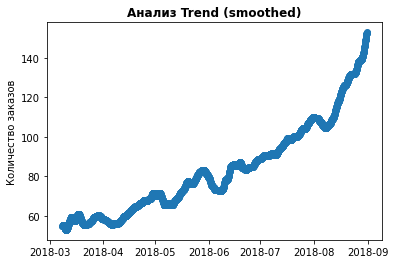

In [12]:
graphs_2(decomposed.trend.rolling(24*7).mean(), 'Trend (smoothed)')

<AxesSubplot:xlabel='datetime'>

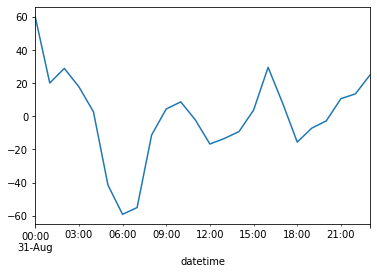

In [13]:
decomposed.seasonal.tail(24).plot(ax=plt.gca())

### Вывод
По результатам анализа линий тренда, можно сделать вывод, что количество заказов растет каждый месяц

## Обучение

In [14]:
def make_features(dataset, max_lag, rolling_mean_size,target):
    dataset['day'] = dataset.index.day
    dataset['dayofweek'] = dataset.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        dataset['lag_{}'.format(lag)] = dataset[target].shift(lag)

    dataset['rolling_mean'] = dataset[target].shift().rolling(rolling_mean_size).mean()
    dataset.dropna(inplace=True)
    return dataset
data_ML=make_features(taxi, 24, 100,'num_orders')

In [15]:
RANDOM_STATE=42
TEST_SIZE=0.1

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data_ML.drop('num_orders', axis=1),
    data_ML['num_orders'],
    shuffle=False,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2,shuffle=False, 
random_state = RANDOM_STATE)


numbers = data_ML.drop('num_orders', axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numbers])
X_test_scaled = scaler.transform(X_test[numbers])
X_valid_scaled = scaler.transform(X_valid[numbers])

X_train = pd.DataFrame(X_train_scaled, columns=numbers)
X_test = pd.DataFrame(X_test_scaled, columns=numbers)
X_valid= pd.DataFrame(X_valid_scaled, columns=numbers)

In [17]:
start_time = time.time()

score =[]

for hyperparam1 in [True, False]:
    for hyperparam2 in [True, False]:
        for hyperparam3 in [1, -1]:
            model_LR = LinearRegression(copy_X=hyperparam1,fit_intercept=hyperparam2,n_jobs=hyperparam3)
            model_LR.fit(X_train,y_train)
            target_predict = model_LR.predict(X_valid)
            RMSE_LR = mean_squared_error( y_valid,target_predict) ** 0.5
            score.append((RMSE_LR, hyperparam1, hyperparam2,hyperparam3))
            
best_lr=min(score)

model_LR = LinearRegression(copy_X=best_lr[1],fit_intercept=best_lr[2],n_jobs=best_lr[3])

model_LR.fit(X_train, y_train)

end_time = time.time()

education_time_LR = end_time - start_time

start_time = time.time()
target_predict = model_LR .predict(X_valid)
end_time = time.time()
prediction_time_LR = end_time - start_time
RMSE_LR = mean_squared_error(y_valid,target_predict) ** 0.5

In [18]:
start_time = time.time()
model_DT = DecisionTreeRegressor(criterion='friedman_mse', 
                              max_depth=15, 
                              random_state=RANDOM_STATE) 
model_DT.fit(X_train, y_train)
end_time = time.time()
education_time_DT = end_time - start_time

start_time = time.time()
target_predict = model_DT.predict(X_valid)
end_time = time.time()
prediction_time_DT = end_time - start_time
RMSE_DT = mean_squared_error( y_valid,target_predict) ** 0.5  

In [19]:
start_time = time.time()
model_R = Ridge(solver='svd',random_state=RANDOM_STATE)
model_R.fit(X_train, y_train)
end_time = time.time()
education_time_R = end_time - start_time

start_time = time.time()
target_predict = model_R.predict(X_valid)
end_time = time.time()
prediction_time_R = end_time - start_time
RMSE_R= mean_squared_error( y_valid,target_predict) ** 0.5

In [20]:
start_time = time.time()
model_CB = CatBoostRegressor(learning_rate=0.5, 
                          random_state=RANDOM_STATE, 
                          verbose=False) 
model_CB.fit(X_train, y_train)
end_time = time.time()
education_time_CB = end_time - start_time

start_time = time.time()
target_predict = model_CB.predict(X_valid)
end_time = time.time()
prediction_time_CB = end_time - start_time
RMSE_CB = mean_squared_error( y_valid,target_predict) ** 0.5

In [21]:
start_time = time.time()
model_LGBM = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=20, 
                      random_state=RANDOM_STATE)
model_LGBM.fit(X_train, y_train)
end_time = time.time()
education_time_LGBM = end_time - start_time

start_time = time.time()
target_predict = model_LGBM.predict(X_valid)
end_time = time.time()
prediction_time_LGBM = end_time - start_time
RMSE_LGBM = mean_squared_error( y_valid,target_predict) ** 0.5

In [22]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'Ridge',
         'CatBoostRegressor',
        'LGBM']
data = {'RMSE':[RMSE_LR,RMSE_DT,RMSE_R,RMSE_CB,RMSE_LGBM],'education_time':[education_time_LR,education_time_DT,education_time_R,education_time_CB,education_time_LGBM],'prediction_time':[prediction_time_LR,prediction_time_DT,prediction_time_R,prediction_time_CB,prediction_time_LGBM]}
display(pd.DataFrame(data=data, index=index).sort_values(by='RMSE',ascending=False))

,RMSE,education_time,prediction_time
DecisionTreeRegressor,43.635745,0.146382,0.002010
CatBoostRegressor,35.105176,6.218642,0.002996
LGBM,34.174536,2.374519,0.090724
LinearRegression,32.959099,0.811917,0.089554
Ridge,32.958977,0.014861,0.084787


###  Выводы
По результатам анализа моделей можно сделать вывод, что величина RMSE самая низкая (32) у Ridge,  время обучения составляет 0.017. 
Стоит остановить выбор на данной модели.

## Тестирование

In [24]:
start_time = time.time()
target_predict = model_R.predict(X_test)
end_time = time.time()
prediction_time_R_test = end_time - start_time

RMSE_R_test = mean_squared_error( y_test,target_predict) ** 0.5

display('prediction_time_Ridge_test ',prediction_time_R_test)
display('RMSE_Ridge_test ',RMSE_R_test)

'prediction_time_Ridge_test '

0.001901865005493164

'RMSE_Ridge_test '

45.80293502472437

###  Выводы
Время выполнения на тестовой выборке составило 0,019 секунд, RMSE=45.8 (подходит заданию)